In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_text
import tensorflow_text as text
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import *
import tensorflow_hub as hub
from keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
final=pd.read_csv('file.csv')

In [ ]:
df = final
df=df.astype(str)
tagging='Patient gender'
labels = sorted(list(df[tagging].unique()))
length = len(labels)
label_count=df.groupby(tagging)[tagging].agg('count')
label_count.to_numpy(dtype=int)
label_count = np.expand_dims(label_count, axis=0)
label_count.shape=(length,1)
labels=np.array(labels)
labels.shape=(length,1)
label_count=np.column_stack((labels,label_count))
data = pd.DataFrame(label_count, columns=['Label', 'Count'])
convert_dict = {'Count': int}
  
data = data.astype(convert_dict)
data

In [ ]:
final['Patient gender'].unique()

In [ ]:
final=final. dropna()

In [ ]:
X=final['Patient dialogue']
y=final['Patient gender']

In [ ]:
lst = list(final['Patient gender'].unique())
len(lst)

8

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [ ]:
x_train

4823    patient: my nani has a pancreatic cancer from ...
1182    My wife, age 45years, has been having low grad...
266     my mother in law fights with her husband at 12...
1383    I have a molar in the back that has most of th...
1591    My Pharmacy told me I had a new prescription f...
                              ...                        
5382    I occasionally use the wrong word in a sentenc...
4356    We did not have an intercourse and also we wer...
4234    Hello doctor,I have a rash for three years. It...
1338    Hello, I have torn my frenulum some weeks ago ...
945      Hello doctor,I am a 57-year-old white male. M...
Name: Patient dialogue, Length: 5051, dtype: object

In [ ]:
X_train_patient_dialogue = x_train.to_numpy()
x_train_patient_dialogue = np.asarray(X_train_patient_dialogue).astype(str)

X_test_patient_dialogue = x_test.to_numpy()
x_test_patient_dialogue = np.asarray(X_test_patient_dialogue).astype(str)


In [ ]:
y_train=pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [ ]:

y_train_ = np.asarray(y_train.values).astype('float32')
y_test_ = np.asarray(y_test.values).astype('float32')

In [ ]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]
seq_length = 512
bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, arguments=dict(seq_length=seq_length))
encoder_inputs = bert_pack_inputs(tokenized_inputs)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
embedding_model = tf.keras.Model(text_inputs, pooled_output)

In [ ]:
from keras.layers import Layer
import keras.backend as K

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
text_input_patient_dialogue = Input(shape=(),dtype=tf.string, name='Patient dialogue')
encode_output_patient_dialogue = embedding_model(text_input_patient_dialogue)

#bilstm_patient_dialogue = Bidirectional(CuDNNLSTM(units=256,return_sequences=True))(encode_output_patient_dialogue)

#att = attention()(bilstm_patient_dialogue)

output = Dense(len(lst), activation='softmax')(encode_output_patient_dialogue)
model = Model(inputs=[text_input_patient_dialogue ], outputs=output)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Patient dialogue (InputLaye  [(None,)]                0         
 r)                                                              
                                                                 
 model (Functional)          (None, 768)               109482241 
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
Total params: 109,488,393
Trainable params: 6,152
Non-trainable params: 109,482,241
_________________________________________________________________


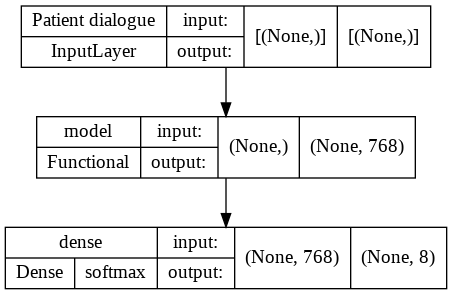

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

# Training...

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', 
                                               patience=5, 
                                               verbose=1)

hist = model.fit(X_train_patient_dialogue, y_train_, 
                epochs=100, 
                batch_size=4, verbose=1,
                callbacks=[early_stopping])

In [ ]:
model.evaluate( X_test_patient_dialogue, y_test_, batch_size=1)

In [ ]:
pred = model.predict( X_test_patient_dialogue)

In [ ]:
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test_, axis=1)

from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='weighted'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))



# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))